In [1]:
import pandas as pd
import seaborn as sns
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
train_df = pd.read_csv('data/train.csv')
building = pd.read_csv('data/building_metadata.csv')
weather_train = pd.read_csv('data/weather_train.csv')

In [14]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])

In [19]:
import sys
sys.path.append("../")
import numpy as np
from util.util import reduce_mem_usage

In [20]:
train_df = reduce_mem_usage(train_df)
building = reduce_mem_usage(building)
weather_train = reduce_mem_usage(weather_train)

NameError: name 'np' is not defined

In [25]:
train_df = train_df.iloc[:100000]
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [26]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [28]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [30]:
weather_train.isnull().sum()/weather_train.shape[0]

site_id               0.000000
timestamp             0.000000
air_temperature       0.000393
cloud_coverage        0.494895
dew_temperature       0.000808
precip_depth_1_hr     0.359791
sea_level_pressure    0.075966
wind_direction        0.044844
wind_speed            0.002175
dtype: float64

In [32]:
building.isnull().sum()/building.shape[0]

site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64

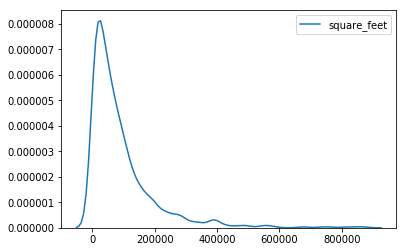

In [52]:
sns.kdeplot(building["square_feet"])

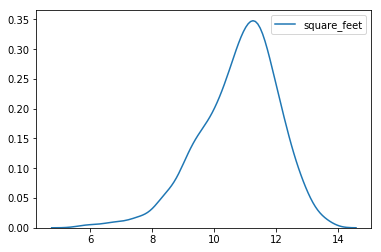

In [51]:
sns.kdeplot(np.log1p(building["square_feet"]))

In [49]:
np.expm1(12)

162753.79141900392

In [42]:
type(train_df['meter_reading'][0])

numpy.float64

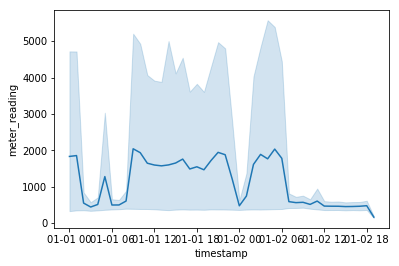

In [33]:
import matplotlib.pyplot as plt
#sns.kdeplot(data=train_df,x='meter_reading')
sns.lineplot(data=train_df,x='timestamp',y='meter_reading')

In [ ]:
train_df.shape

In [63]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
building['primary_use']=le.fit_transform(building['primary_use'])
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


In [5]:
building['primary_use'].unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [66]:
import gc
def prepare_data(X, building_data, weather_data, test=False):
    X = X.merge(building_data, on="building_id", how="left")
    X = X.merge(weather_data, on=["site_id", "timestamp"], how="left")
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
    
    gc.collect()
    
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)    
    
    drop_features = ["timestamp", "sea_level_pressure", "wind_direction"]

    X.drop(drop_features, axis=1, inplace=True)

    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

In [67]:
train_x,train_y = prepare_data(train_df, building, weather_train,test=False)

In [68]:
train_x.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,wind_speed,hour,weekday,is_holiday
0,0,0,0,0,8.913685,2008.0,NaN,25.0,6.0,20.0,NaN,0.0,0,4,1
1,1104,1,13,9,12.204687,NaN,NaN,-8.3,8.0,-12.2,NaN,4.1,0,4,1
2,1104,0,13,9,12.204687,NaN,NaN,-8.3,8.0,-12.2,NaN,4.1,0,4,1
3,1103,0,13,7,10.081801,NaN,NaN,-8.3,8.0,-12.2,NaN,4.1,0,4,1
4,1102,2,13,6,11.375822,NaN,NaN,-8.3,8.0,-12.2,NaN,4.1,0,4,1


In [71]:
X_half_1 = train_x[:int(train_x.shape[0] / 2)]
X_half_2 = train_x[int(train_x.shape[0] / 2):]

y_half_1 = train_y[:int(train_x.shape[0] / 2)]
y_half_2 = train_y[int(train_x.shape[0] / 2):]

categorical_features = ["building_id", "site_id", "meter", "primary_use", "hour", "weekday"]

d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

watchlist_1 = [d_half_1, d_half_2]
watchlist_2 = [d_half_2, d_half_1]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}

print("Building model with first half and validating on second half:")
model_half_1 = lgb.train(params, train_set=d_half_1, num_boost_round=1000, valid_sets=watchlist_1, verbose_eval=200, early_stopping_rounds=200)

print("Building model with second half and validating on first half:")
model_half_2 = lgb.train(params, train_set=d_half_2, num_boost_round=1000, valid_sets=watchlist_2, verbose_eval=200, early_stopping_rounds=200)

NameError: name 'lgb' is not defined